<a href="https://colab.research.google.com/github/InutilemMachina/DataSciRepo/blob/main/Classification_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_titanic_data():
    tarball_path = Path("datasets/titanic.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/titanic.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as titanic_tarball:
            titanic_tarball.extractall(path="datasets")
    return [pd.read_csv(Path("datasets/titanic") / filename)
            for filename in ("train.csv", "test.csv")]

In [ ]:
train_data, test_data = load_titanic_data()

In [ ]:
# test_data.head() # Survived not included due to Kaggle contest

In [ ]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The attributes have the following meaning:

- PassengerId: a unique identifier for each passenger
- Survived: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
- Pclass: passenger class.
- Name, Sex, Age: self-explanatory
- SibSp: how many siblings & spouses of the passenger aboard the Titanic.
- Parch: how many children & parents of the passenger aboard the Titanic.
- Ticket: ticket id
- Fare: price paid (in pounds)
- Cabin: passenger's cabin number
- Embarked: where the passenger embarked the Titanic

The goal is to predict whether or not a passenger survived based on attributes such as their age, sex, passenger class, where they embarked and so on.

In [ ]:
!pip install summarytools
from summarytools import dfSummary

dfSummary(train_data)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,PassengerId[int64],Mean (sd) : 446.0 (257.4)min < med < max:1.0 < 446.0 < 891.0IQR (CV) : 445.0 (1.7),891 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAB8ElEQVR4nO3Xv27aYBhH4ddWikxAtvhTuICO3ZBYuICOvdheBENnhi6d2JCQZYSbqBZ11yxJMVaTnuo8K/x4v+EMSdK2bUj/uvStHyBd4+6tH6D/R5Ikw4gY3Dj/2bbtw3Mf/jHUnsfTiPh147bvnnqb+u5sOp1+KopidMv4dDqVSZJ8eS7WF0NNkmQ4m80+53k+6Xr4crm8q+v6w3g8/p6mafOae+pt6rsjIpqmySLi43q9/jqfz09dtlVVZdvtdnI8HgcR0T3UiBjkeT7ZbDYPRVE8djm+3+8nu93u/Wq1+rZcLssu27576m3qu5/s77MsaxaLxY+u+4gYvvThVX+jFkXx2PV4WZbDiIjRaNR523dPvU1999P93+J//UIwVCEYqhAMVQiGKgRDFYKhCsFQhWCoQjBUIRiqEAxVCIYqBEMVgqEKwVCFYKhCMFQhGKoQDFUIhioEQxWCoQrBUIVgqEIwVCEYqhAMVQiGKgRDFYKhCsFQhWCoQjBUIRiqEAxVCIYqBEMVgqEKwVCFYKhCMFQhGKoQDFUIhioEQxWCoQrBUIVgqEIwVCEYqhAMVQiGKgRDFYKhCsFQhWCoQjBUIRiqEAxVCIYqBEMVwt01X6qqKuv6w+fzOYuIqOs6OxwO96+5p96mvrvv/pq+fgOe9DS+8Np05AAAAABJRU5ErkJggg=="">",0(0.0%)
2,Survived[int64],1. 02. 1,549 (61.6%)342 (38.4%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABNElEQVR4nO3bQWrDMBRF0a9iQjORMAYvJovoYrsI7cYYa9CETNRB9/Ak+u5ZwU+4GBL8Uu89AIUUEfeIuI0+xNi79/4cfYTCsm3bV855HX2Iq9bamVL6dghuyTmvj8fjWUp5jT7GzXVdn7XW9TiOW0T8/9giIkopr33ff0YfY+o++gCVj9EHwAexQYbYIENskCE2yBAbZIgNMsQGGWKDDLFBhtggQ2yQITbIEBtkiA0yS8TfS3yjD3Hk9r0vrbWz1rqG0Ut8M2mtnRHxHn2HAoOX8WwGL4kpH1Tcnmw2T5EZWU35nGZzM7KZ8rnN5mbkNuXjF/dA/KkLGWKDDLFBhtggQ2yQITbIEBtkiA0yxAYZYoMMsUGG2CBDbJAhNsgQG2RspnwOn3F2VlM+p9ncjBi8QOYXCltq37DnnSoAAAAASUVORK5CYII="">",0(0.0%)
3,Pclass[int64],1. 32. 13. 2,491 (55.1%)216 (24.2%)184 (20.7%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABl0lEQVR4nO3bQWrbYBSF0aciQjORMAYvxovoYrsI7cYYa5CETJRBJi20s+T+P9I5K3iYDxsJ32HbtoKEH60P4DiGqnquqqfWh+zM+7Ztr62P6M14Pp9/TdN0an3Inqzreh+G4bfg/jZO03S6Xq+v8zy/tT5mDx6Px89lWU632+2pqsT2h7Gqap7nt8vl8tL6mB15bn1AjzwgECM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNmrPr8D1brQ/bCZ/l/47qu92VZTuU/WF9mXdd7Vb23vqM3NgjfwwbhHwZTPlJ6/mbz7bAz3a6rLJT2p8t1lYXSPvW8rvJ0vDNe6hIjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjpst1VW/38DW6XVdZKO2PDQIx1lXEeEAgpoefUT+XB9F8ymeydxxNp3wme8fSw5Svq1cufB8PCMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIaTrlM9k7luZTPpO947BBIMaUj5gPSryjSkEJaC0AAAAASUVORK5CYII="">",0(0.0%)
4,Name[object],"1. Braund, Mr. Owen Harris2. Boulos, Mr. Hanna3. Frolicher-Stehli, Mr. Maxmilli4. Gilinski, Mr. Eliezer5. Murdlin, Mr. Joseph6. Rintamaki, Mr. Matti7. Stephenson, Mrs. Walter Bertra8. Elsbury, Mr. William James9. Bourke, Miss. Mary10. Chapman, Mr. John Henry11. other",1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)881 (98.9%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADXElEQVR4nO3cwWkbYRRG0TdGOPZGQhhcQtKDi0ixKUJFpAdjPIvY8WaySBYpINwB5ZwK/sWFh2A+Ldu2DRRu9n4A/w+xkREbGbGRERsZsZERGxmxkREbGbGRuVmW5cuyLHd7P4TrdzMzn2fm094P4fo5o2TERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRG5mZmvs/Mz70fwvVb/IsRFWeUjNjIWFeRsa4i44ySERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZExeCFj8ELGGSUjNjIGL2QMXsg4o2TERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZAxeyBi8kHFGyYiNjNjIWFeRsa4i44ySERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZGxriJjXUXGGSUjNjIGL2QMXsg4o2TERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZAxeyBi8kHFGyYiNjMELGYMXMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZGxriJjXUXGGSUjNjLWVWSsq8g4o2TERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZAxeyBi8kHFGyYiNjMELGYMXMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9knFEyYiMjN

In [ ]:
# separate X and y from the original train set
X = train_data.copy()
y = train_data['Survived']
X = X.drop('Survived', axis = 1)

In [ ]:
X.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [ ]:
y.name

'Survived'

In [ ]:
X = X.drop(['PassengerId', 'Name', 'Ticket'], axis = 1)
X.Cabin = X.Cabin.str[0]  # e.g. G6 -> G, or B96 B98 -> P
# dfSummary(X)
# Still 687 mising values, might be easier to drop

In [ ]:
# split now and forget test_set until the very end
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn import set_config
set_config(display='diagram')

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler',  StandardScaler())
])

In [ ]:
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('encoder', OneHotEncoder(sparse = False))
])

In [ ]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,male,22.0,1,0,7.2500,NaN,S
1,1,female,38.0,1,0,71.2833,C,C
2,3,female,26.0,0,0,7.9250,NaN,S
3,1,female,35.0,1,0,53.1000,C,S
4,3,male,35.0,0,0,8.0500,NaN,S


## Előklasszifikacio a Cabin értékek extrapolására

In [ ]:
X.info()  # a Cabin kategoria ~ 80%-a hiányzik, azt igen nehéz lenne előre jelezni. De 200 adat mondjuk van. És arra lehetne egy klasszifikcaiot csinálni.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Age       714 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Cabin     204 non-null    object 
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(3)
memory usage: 55.8+ KB


In [ ]:
Cabin = X.dropna(subset = ['Cabin'])
Cabin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204 entries, 1 to 889
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    204 non-null    int64  
 1   Sex       204 non-null    object 
 2   Age       185 non-null    float64
 3   SibSp     204 non-null    int64  
 4   Parch     204 non-null    int64  
 5   Fare      204 non-null    float64
 6   Cabin     204 non-null    object 
 7   Embarked  202 non-null    object 
dtypes: float64(2), int64(3), object(3)
memory usage: 14.3+ KB


In [ ]:
# separate X and y from the Cabin subset
Cabin_X = Cabin.copy()
Cabin_y = Cabin_X['Cabin']
Cabin_X = Cabin_X.drop('Cabin', axis = 1)

# train-test-split Cabin subset df
Cabin_X_train, Cabin_X_test, Cabin_y_train, Cabin_y_test = train_test_split(Cabin_X, Cabin_y, test_size=0.2, random_state = 42)

In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs = ['Age','SibSp','Parch','Fare']
cat_attribs = ['Pclass', 'Sex', 'Embarked']

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

In [ ]:
# preprocessing
Cabin_X_train_prep = preprocessing.fit_transform(Cabin_X_train)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
Cabin_forest_clf = RandomForestClassifier(n_estimators=100, random_state=7)
Cabin_forest_clf.fit(Cabin_X_train_prep, Cabin_y_train)
# cross_val_score(Cabin_forest_clf, Cabin_X_train_prep, Cabin_y_train, cv=10).mean().round(2)  # 0.34

RandomForestClassifier(random_state=7)

In [ ]:
from sklearn.linear_model import LogisticRegression

Cabin_logreg_clf = LogisticRegression(random_state = 0)
Cabin_logreg_clf.fit(Cabin_X_train_prep, Cabin_y_train)
# cross_val_score(Cabin_logreg_clf, Cabin_X_train_prep, Cabin_y_train, cv=3).mean().round(2)  # 0.31

LogisticRegression(random_state=0)

nagyon kicsi az accuracy ~30%, ezért ezt most félretesszük. Sőt, ki is dobjuk.

In [ ]:
X = X.drop(['Cabin'], axis = 1)

In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs = ['Age','SibSp','Parch','Fare']

cat_attribs = ['Pclass', 'Sex', 'Embarked']

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

preprocessing

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Age', 'SibSp', 'Parch', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(sparse=False))]),
                                 ['Pclass', 'Sex', 'Embarked'])])

In [ ]:
X_train_prep = preprocessing.fit_transform(X_train)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
X_train_prep

array([[ 1.25363981, -0.47072241, -0.47934164, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47728209, -0.47072241, -0.47934164, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.21508667, -0.47072241, -0.47934164, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.90745543,  1.23056874, -0.47934164, ...,  0.        ,
         0.        ,  1.        ],
       [-1.16965085,  0.37992316,  2.04874166, ...,  0.        ,
         0.        ,  1.        ],
       [-0.63114182, -0.47072241,  0.78470001, ...,  0.        ,
         0.        ,  1.        ]])

In [ ]:
# recover a dataframe:
X_train_prep_df = pd.DataFrame(
    X_train_prep,
    columns = preprocessing.get_feature_names_out(),
    index = X_train.index)
X_train_prep_df.columns

Index(['num__Age', 'num__SibSp', 'num__Parch', 'num__Fare', 'cat__Pclass_1',
       'cat__Pclass_2', 'cat__Pclass_3', 'cat__Sex_female', 'cat__Sex_male',
       'cat__Embarked_C', 'cat__Embarked_Q', 'cat__Embarked_S'],
      dtype='object')

**Classification model candidates**

https://scikit-learn.org/stable/user_guide.html

1.1.2. Ridge regression and classification

1.4.1. Support Vector Machines Classification

1.5.1. Stochastic Gradient Descent Classification

1.6.2. Nearest Neighbors Classification

1.6.5. Nearest Centroid Classifier

1.7.3. Gaussian Process Classification (GPC)

1.10.1. Decision Trees Classification

1.11. Ensemble methods

? Logistic Regression ?

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [ ]:
from sklearn.linear_model import RidgeClassifierCV
ridge_clf = RidgeClassifierCV(alphas=(0.1, 1.0, 10.0), fit_intercept=False, cv = 3)  # RidgeClassifierCV(alphas=(0.1, 1.0, 10.0), *, fit_intercept=True, scoring=None, cv=None, class_weight=None, store_cv_values=False
ridge_clf.fit(X_train_prep, y_train)
ridge_clf.score(X_train_prep, y_train).round(2)
# cross_val_score in RidgeClassifierCV cv = 3

0.8

In [ ]:
param_grid_ridge = {
    'alphas': [(0.1, 1.0, 10.0), (0.01, 0.1, 1.0), (1.0, 10.0, 100.0)],
    'fit_intercept': [True, False]}

grid_search_ridge = GridSearchCV(RidgeClassifierCV(), param_grid_ridge, cv=3, scoring='accuracy')
grid_search_ridge.fit(X_train_prep, y_train)
best_params_ridge = grid_search_ridge.best_params_
best_score_ridge = grid_search_ridge.best_score_

In [ ]:
from sklearn.svm import SVC
# SVC(*, C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None
svc_clf = SVC(gamma='auto', random_state=7)
svc_clf.fit(X_train_prep, y_train)
# svc_clf.score(X_train_prep, y_train).round(2)
cross_val_score(svc_clf, X_train_prep, y_train, cv=3, scoring="accuracy").mean().round(2)

0.82

In [ ]:
param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
grid_search_svc = GridSearchCV(SVC(), param_grid_svc, cv=3, scoring='accuracy')
grid_search_svc.fit(X_train_prep, y_train)
best_params_svc = grid_search_svc.best_params_
best_score_svc =  grid_search_svc.best_score_

In [ ]:
from sklearn.svm import LinearSVC
# LinearSVC(penalty='l2', loss='squared_hinge', *, dual='warn', tol=0.0001, C=1.0, multi_class='ovr', fit_intercept=True, intercept_scaling=1, class_weight=None, verbose=0, random_state=None, max_iter=1000)
linsvc_clf = LinearSVC(random_state=7)
linsvc_clf.fit(X_train_prep, y_train)
# linsvc_clf.score(X_train_prep, y_train).round(2)
cross_val_score(linsvc_clf, X_train_prep, y_train, cv=3, scoring="accuracy").mean().round(2)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.8

In [ ]:
param_grid_linsvc = {
    'C': [0.1, 1, 10]
}
grid_search_linsvc = GridSearchCV(linsvc_clf, param_grid=param_grid_linsvc, scoring='accuracy', cv=3)
grid_search_linsvc.fit(X_train_prep, y_train)
best_params_linsvc = grid_search_linsvc.best_params_
best_score_linsvc = grid_search_linsvc.best_score_

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

In [ ]:
from sklearn.linear_model import SGDClassifier
# SGDClassifier(loss='hinge', *, penalty='l2', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=1000, tol=0.001, shuffle=True, verbose=0, epsilon=0.1, n_jobs=None, random_state=None, learning_rate='optimal', eta0=0.0, power_t=0.5, early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, class_weight=None, warm_start=False, average=False)
sgd_clf = SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001)
sgd_clf.fit(X_train_prep, y_train)
# sgd_clf.score(X_train_prep, y_train).round(2)
cross_val_score(sgd_clf, X_train_prep, y_train, cv=3, scoring="accuracy").mean().round(2)

0.73

In [ ]:
param_grid_sgd = {
    'loss': ['hinge', 'log', 'modified_huber'],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01]
}
grid_search_sgd = GridSearchCV(sgd_clf, param_grid=param_grid_sgd, scoring='accuracy', cv=3)
grid_search_sgd.fit(X_train_prep, y_train)
best_params_sgd = grid_search_sgd.best_params_
best_score_sgd = grid_search_sgd.best_score_

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skle

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
# KNeighborsClassifier(n_neighbors=5, *, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)
kn_clf = KNeighborsClassifier(n_neighbors=5, algorithm='auto')
kn_clf.fit(X_train_prep, y_train)
# kn_clf.score(X_train_prep, y_train).round(2)
cross_val_score(kn_clf, X_train_prep, y_train, cv=3, scoring="accuracy").mean().round(2)

0.8

In [ ]:
param_grid_kn = {
    'n_neighbors': [3, 5, 7],
    'algorithm': ['auto', 'ball_tree', 'kd_tree']
}
grid_search_kn = GridSearchCV(kn_clf, param_grid=param_grid_kn, scoring='accuracy', cv=3)
grid_search_kn.fit(X_train_prep, y_train)
best_params_kn = grid_search_kn.best_params_
best_score_kn = grid_search_kn.best_score_

In [ ]:
from sklearn.neighbors import NearestCentroid
# NearestCentroid(metric='euclidean', *, shrink_threshold=None)
nc_clf = NearestCentroid()
nc_clf.fit(X_train_prep, y_train)
# nc_clf.score(X_train_prep, y_train).round(2)
cross_val_score(nc_clf, X_train_prep, y_train, cv=3, scoring="accuracy").mean().round(2)

0.78

In [ ]:
# NearestCentroid doesn't have hyperparameters to tune
best_params_nc = {}  # There are no hyperparameters
best_score_nc = cross_val_score(nc_clf, X_train_prep, y_train, cv=3, scoring="accuracy").mean()

In [ ]:
from sklearn.gaussian_process import GaussianProcessClassifier
# GaussianProcessClassifier(kernel=None, *, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=0, max_iter_predict=100, warm_start=False, copy_X_train=True, random_state=None, multi_class='one_vs_rest', n_jobs=None)
gp_clf = GaussianProcessClassifier(random_state = 7)
gp_clf.fit(X_train_prep, y_train)
# gp_clf.score(X_train_prep, y_train).round(2)
cross_val_score(gp_clf, X_train_prep, y_train, cv=3, scoring="accuracy").mean().round(2)

0.81

In [ ]:
# GaussianProcessClassifier has complex hyperparameters, consult documentation for tuning

# Create GridSearchCV instance
# It's important to specify the appropriate parameter ranges for GaussianProcessClassifier

# Fit GridSearchCV to data

# Get best parameters and best score
# GaussianProcessClassifier hyperparameter tuning is more involved and requires custom handling
# Please refer to the documentation and resources on how to properly tune this classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
# DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0
dt_clf = DecisionTreeClassifier(random_state=7)
dt_clf.fit(X_train_prep, y_train)
# dt_clf.score(X_train_prep, y_train).round(2) # beware overfitting and use cross-validation
cross_val_score(dt_clf, X_train_prep, y_train, cv=10).mean().round(2)

0.76

In [ ]:
param_grid_dt = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_search_dt = GridSearchCV(dt_clf, param_grid=param_grid_dt, scoring='accuracy', cv=3)
grid_search_dt.fit(X_train_prep, y_train)
best_params_dt = grid_search_dt.best_params_
best_score_dt = grid_search_dt.best_score_

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
forest_clf = RandomForestClassifier(n_estimators=100, random_state=7)
forest_clf.fit(X_train_prep, y_train)
# forest_clf.score(X_train_prep, y_train).round(2) # beware overfitting and use cross-validation
cross_val_score(forest_clf, X_train_prep, y_train, cv=10).mean().round(2)

0.8

In [ ]:
param_grid_forest = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_search_forest = GridSearchCV(forest_clf, param_grid=param_grid_forest, scoring='accuracy', cv=3)
grid_search_forest.fit(X_train_prep, y_train)
best_params_forest = grid_search_forest.best_params_
best_score_forest = grid_search_forest.best_score_

In [ ]:
import pandas as pd

# Create a list of dictionaries containing classifier name, best parameters, and best score
clf_data = [
    {"name": "Ridge", "best_params": best_params_ridge, "best_score": best_score_ridge},
    {"name": "SVC", "best_params": best_params_svc, "best_score": best_score_svc},
    {"name": "LinearSVC", "best_params": best_params_linsvc, "best_score": best_score_linsvc},
    {"name": "SGDClassifier", "best_params": best_params_sgd, "best_score": best_score_sgd},
    {"name": "KNeighborsClassifier", "best_params": best_params_kn, "best_score": best_score_kn},
    {"name": "NearestCentroid", "best_params": best_params_nc, "best_score": best_score_nc},
    # GaussianProcessClassifier requires special handling
    {"name": "DecisionTreeClassifier", "best_params": best_params_dt, "best_score": best_score_dt},
    {"name": "RandomForestClassifier", "best_params": best_params_forest, "best_score": best_score_forest}
]

# Create a DataFrame from the list of dictionaries
clf_df = pd.DataFrame(clf_data)
clf_df = clf_df.sort_values(by = 'best_score', ascending = False)
clf_df

,name,best_params,best_score
7,RandomForestClassifier,"{'max_depth': 10, 'min_samples_split': 10, 'n_...",0.828665
1,SVC,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}",0.825858
3,SGDClassifier,"{'alpha': 0.01, 'loss': 'log', 'penalty': 'l2'}",0.810404
4,KNeighborsClassifier,"{'algorithm': 'auto', 'n_neighbors': 5}",0.797770
2,LinearSVC,{'C': 0.1},0.797764
0,Ridge,"{'alphas': (0.01, 0.1, 1.0), 'fit_intercept': ...",0.792162
6,DecisionTreeClassifier,"{'max_depth': None, 'min_samples_split': 10}",0.785123
5,NearestCentroid,{},0.775272


menjünk tovább SVC és RandomForestClassifier-ekkel

In [ ]:
# legjobb parameterekkel lefuttatjuk azokat ujra és a cv_score-oknak kell egy boxplot

In [ ]:
best_params_svc

{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

In [ ]:
svc_clf = SVC(C = 1, gamma = 'scale', kernel = 'rbf', random_state=7)
svc_clf.fit(X_train_prep, y_train)
svc_scores = cross_val_score(svc_clf, X_train_prep, y_train, cv=10, scoring="accuracy")

In [ ]:
best_params_forest

{'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}

In [ ]:
forest_clf = RandomForestClassifier(n_estimators=200, max_depth = 20, min_samples_split=10, random_state=7)
forest_clf.fit(X_train_prep, y_train)
forest_scores = cross_val_score(forest_clf, X_train_prep, y_train, cv=10, scoring="accuracy")

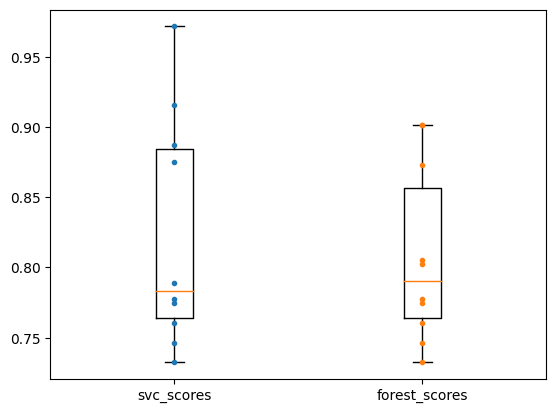

In [ ]:
import matplotlib.pyplot as plt

plt.boxplot([svc_scores, forest_scores], showfliers = True, labels = ['svc_scores','forest_scores'])
plt.plot([1]*10, svc_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.show()

Feature engineering

In [ ]:
# relatives
X_train['Relatives'] = X_train['SibSp'] + X_train['Parch']

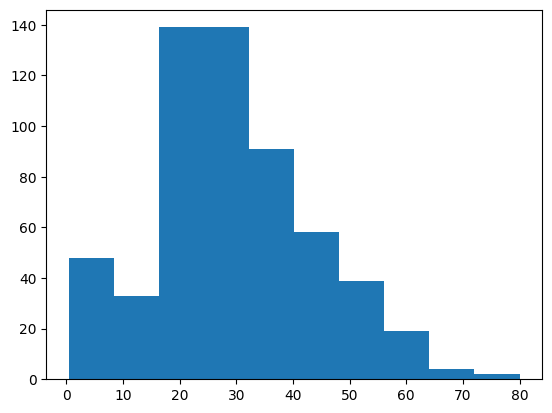

In [ ]:
plt.hist(X_train.Age)
plt.show()

In [ ]:
# age binning
X_train['Age Cat'] = pd.cut(X_train['Age'],
                                 bins=[0., 20, 40, 60, 80],
                                 labels=['to20', 'to40', 'to60', 'to80'])

# Ezt KBinsDiscretizer-rel fogjuk megoldani a pipeline-ban

most rakjuk össze az elejétől

In [ ]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_titanic_data():
    tarball_path = Path("datasets/titanic.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/titanic.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as titanic_tarball:
            titanic_tarball.extractall(path="datasets")
    return [pd.read_csv(Path("datasets/titanic") / filename)
            for filename in ("train.csv", "test.csv")]

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import set_config
set_config(display='diagram')
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
import matplotlib.pyplot as plt

In [ ]:
train_data, test_data = load_titanic_data()

# separate X and y from the original train set
X = train_data.copy()
y = train_data['Survived']
X = X.drop('Survived', axis = 1)

X = X.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
331,1,male,45.5,0,0,28.5000,S
733,2,male,23.0,0,0,13.0000,S
382,3,male,32.0,0,0,7.9250,S
704,3,male,26.0,1,0,7.8542,S
813,3,female,6.0,4,2,31.2750,S


In [ ]:
from sklearn.preprocessing import FunctionTransformer

def column_adder(X):
    return X[:, [0]] + X[:, [1]]
def column_adder_name(function_transformer, feature_names_in):
    return [f"{feature_names_in[0]}_{feature_names_in[1]}"]
def column_adder_pipeline():
    return Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('transformer', FunctionTransformer(column_adder, feature_names_out=column_adder_name)),
        ('scaler', StandardScaler()),
    ])

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import KBinsDiscretizer

add_pipeline = Pipeline([
    ('column_add',  column_adder_pipeline()),
])

age_bucketizing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('discretizer', KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='uniform')),
    ('scaler', StandardScaler()),
])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler',  StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('encoder', OneHotEncoder(sparse_output = False))
])

add_attribs = ['SibSp','Parch']
age_attribs = ['Age']
num_attribs = ['SibSp','Parch','Fare']
cat_attribs = ['Pclass', 'Sex', 'Embarked']

preprocessing = ColumnTransformer([
    ('add', add_pipeline, add_attribs),
    ('age', age_bucketizing_pipeline, age_attribs),
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs),
])

X_train_prep = preprocessing.fit_transform(X_train)

In [ ]:
# recover a dataframe:
X_train_prep = pd.DataFrame(
    X_train_prep,
    columns=preprocessing.get_feature_names_out())

X_train_prep.columns

Index(['add__SibSp_Parch', 'age__Age', 'num__SibSp', 'num__Parch', 'num__Fare',
       'cat__Pclass_1', 'cat__Pclass_2', 'cat__Pclass_3', 'cat__Sex_female',
       'cat__Sex_male', 'cat__Embarked_C', 'cat__Embarked_Q',
       'cat__Embarked_S'],
      dtype='object')

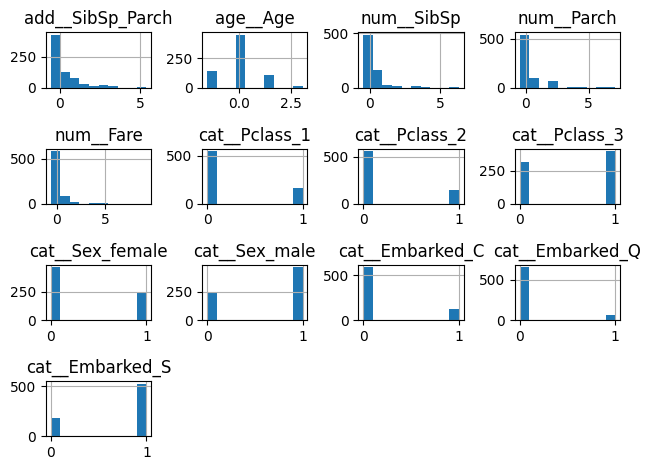

In [ ]:
X_train_prep.hist()
plt.tight_layout()
plt.show()

In [ ]:
svc_clf = SVC(C = 1, gamma = 'scale', kernel = 'rbf', random_state=7)
forest_clf = RandomForestClassifier(n_estimators=200, max_depth = 20, min_samples_split=10, random_state=7)

In [ ]:
full_pipeline_svc = Pipeline([
    ('preprocessing', preprocessing),
    ('svc_clf_model', svc_clf)  # svc_clf = SVC(C = 1, gamma = 'scale', kernel = 'rbf', random_state=7)
])

full_pipeline_forest = Pipeline([
    ('preprocessing', preprocessing),
    ('forest_clf_model', forest_clf)  # forest_clf = RandomForestClassifier(n_estimators=200, max_depth = 20, min_samples_split=10, random_state=7)
])

In [ ]:
full_pipeline_svc

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('add',
                                                  Pipeline(steps=[('column_add',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('transformer',
                                                                                    FunctionTransformer(feature_names_out=<function column_adder_name at 0x7ab3b930ac20>,
                                                                                                        func=<function column_adder at 0x7ab3b930ab90>)),
                                                                                   ('scaler',
                                                                                    StandardScaler())]))]),
                                                  ['SibSp', 'P...
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['SibSp', 'Parch', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['Pclass', 'Sex',
                                                   'Embarked'])])),
                ('svc_clf_model', SVC(C=1, random_state=7))])

In [ ]:
full_pipeline_svc.fit(X_train, y_train)  # svc_clf.fit(X_train_prep, y_train)
svc_scores = cross_val_score(full_pipeline_svc, X_train, y_train, cv=10, scoring="accuracy")

In [ ]:
full_pipeline_forest.fit(X_train, y_train)  # svc_clf.fit(X_train_prep, y_train)
forest_scores = cross_val_score(full_pipeline_forest, X_train, y_train, cv=10, scoring="accuracy")

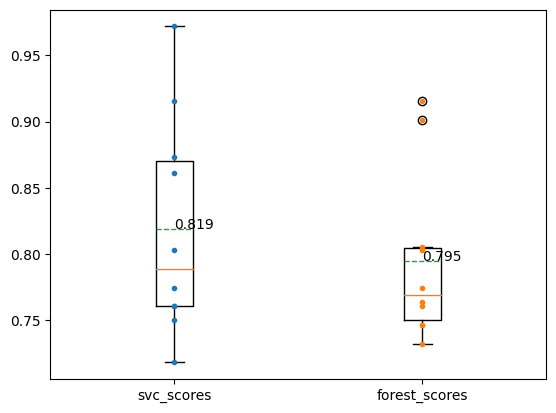

In [ ]:
import matplotlib.pyplot as plt

plt.boxplot([svc_scores, forest_scores], showfliers = True,  meanline='red', showmeans=True, labels = ['svc_scores','forest_scores'])
plt.plot([1]*10, svc_scores, ".")
plt.text(1,svc_scores.mean().round(3),str(svc_scores.mean().round(3)))
plt.plot([2]*10, forest_scores, ".")
plt.text(2,forest_scores.mean().round(3),str(forest_scores.mean().round(3)))
plt.show()

menjünk tivább a forest-tel, mert az konzekvensebb

    RandomForestClassifier
        n_estimators=100, *,
        criterion='gini',
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        min_weight_fraction_leaf=0.0,
        max_features='sqrt',
        max_leaf_nodes=None,
        min_impurity_decrease=0.0,
        bootstrap=True,
        oob_score=False,
        n_jobs=None,
        random_state=None,
        verbose=0,
        warm_start=False,
        class_weight=None,
        ccp_alpha=0.0,
        max_samples=None)

In [ ]:
from sklearn.model_selection import GridSearchCV

# # worth to make pipeline for fine-tuning
# full_pipeline_forest = Pipeline([
#     ('preprocessing', preprocessing),
#     ('forest_clf_model', forest_clf)  # forest_clf = RandomForestClassifier(n_estimators=200, max_depth = 20, min_samples_split=10, random_state=7)
# ])

# hyperparameters
param_grid = {
    'forest_clf_model__n_estimators': [100, 200, 300],
    'forest_clf_model__max_depth': [3, 5, 7],
    'forest_clf_model__min_samples_split': [2, 5, 10],
    'forest_clf_model__min_samples_leaf': [1, 2, 4]
}

# construct
grid_search = GridSearchCV(full_pipeline_forest,
                           param_grid,
                           scoring = 'accuracy',
                           cv = 5)  # 5-fold cross validation

# search
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('add',
                                                                         Pipeline(steps=[('column_add',
                                                                                          Pipeline(steps=[('imputer',
                                                                                                           SimpleImputer(strategy='median')),
                                                                                                          ('transformer',
                                                                                                           FunctionTransformer(feature_names_out=<function column_adder_name at 0x7ab3b930ac20>,
                                                                                                                               func=<function column_adder at 0x7ab3b930ab90>)),
                                                                                                          ('scaler',
                                                                                                           Standa...
                                                                         ['Pclass',
                                                                          'Sex',
                                                                          'Embarked'])])),
                                       ('forest_clf_model',
                                        RandomForestClassifier(max_depth=20,
                                                               min_samples_split=10,
                                                               n_estimators=200,
                                                               random_state=7))]),
             param_grid={'forest_clf_model__max_depth': [3, 5, 7],
                         'forest_clf_model__min_samples_leaf': [1, 2, 4],
                         'forest_clf_model__min_samples_split': [2, 5, 10],
                         'forest_clf_model__n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [ ]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_forest_clf_model__max_depth,param_forest_clf_model__min_samples_leaf,param_forest_clf_model__min_samples_split,param_forest_clf_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
49,0.333421,0.006513,0.024760,0.000871,5,4,5,200,"{'forest_clf_model__max_depth': 5, 'forest_clf...",0.804196,0.846154,0.816901,0.788732,0.845070,0.820211,0.022580,1
46,0.357895,0.036937,0.024514,0.001466,5,4,2,200,"{'forest_clf_model__max_depth': 5, 'forest_clf...",0.804196,0.846154,0.816901,0.788732,0.845070,0.820211,0.022580,1
36,0.340926,0.234582,0.029624,0.023341,5,2,2,100,"{'forest_clf_model__max_depth': 5, 'forest_clf...",0.811189,0.846154,0.809859,0.795775,0.838028,0.820201,0.018848,3
30,0.185747,0.004117,0.018588,0.001531,5,1,5,100,"{'forest_clf_model__max_depth': 5, 'forest_clf...",0.804196,0.853147,0.809859,0.795775,0.838028,0.820201,0.021739,3
78,0.184772,0.004538,0.017825,0.000557,7,4,10,100,"{'forest_clf_model__max_depth': 7, 'forest_clf...",0.811189,0.853147,0.830986,0.781690,0.823944,0.820191,0.023580,5
